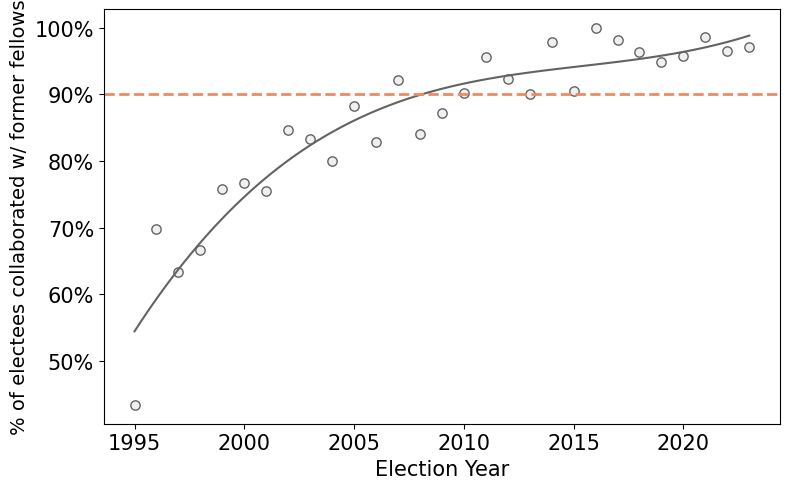

In [7]:
# fig1（a）
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter


df = pd.read_excel("ACM_fellow_electron_year_percentage.xlsx", engine="openpyxl")
fig = plt.subplots(figsize=(8,5))

# scatter plot
plt.scatter(df['Fellow Year'], df['percentage_per_year'], color='#f0f0f0', edgecolors="#636363", label='', s=45)


coefficients = np.polyfit(df['Fellow Year'], df['percentage_per_year'], 3)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(min(df['Fellow Year']), max(df['Fellow Year']), 100)
ys_fitted = polynomial(x_axis)

# fitting curve
plt.plot(x_axis, ys_fitted, color='#636363', label='')
plt.axhline(y=0.90, color='#ef8a62', linestyle='--', label='', lw=2)

plt.xlabel('Election Year',fontsize = 15)
plt.ylabel('% of electees collaborated w/ former fellows',fontsize = 14)
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
# plt.savefig('fig1(a).svg', format='svg')
plt.show()

Mean value for Total without fellow: 27.583333333333332
Mean value for Total with fellow: 23.788638262322472
Mean value for 1994-2003 without fellow: 27.56595744680851
Mean value for 1994-2003 with fellow: 23.2
Mean value for 2004-2013 without fellow: 26.68888888888889
Mean value for 2004-2013 with fellow: 22.662125340599456
Mean value for 2014-2023 without fellow: 29.8
Mean value for 2014-2023 with fellow: 24.755172413793105


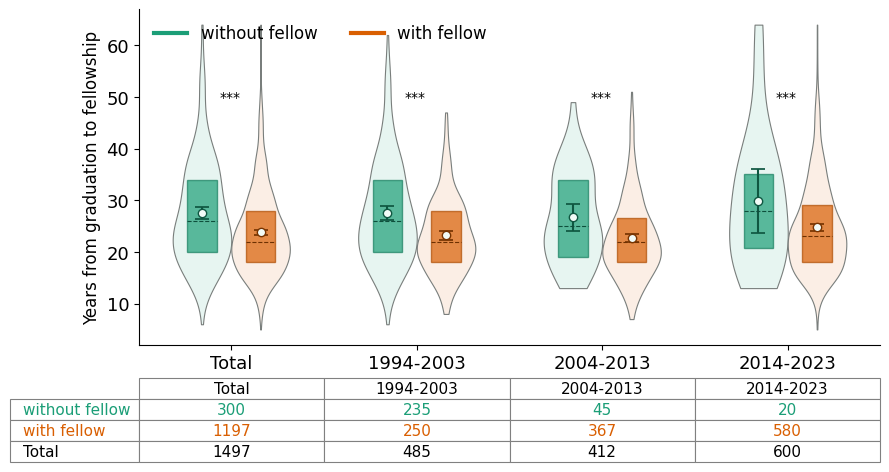

In [6]:
# fig1（b）
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
import numpy as np
from matplotlib.patches import Patch
from matplotlib import colors
import matplotlib.lines as mlines


def darken_color(color, factor):
    r, g, b, a = colors.to_rgba(color)
    r = max(0, min(255, r * factor))
    g = max(0, min(255, g * factor))
    b = max(0, min(255, b * factor))
    return (r, g, b, a)


def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


data = pd.read_excel("ACM_fellow_characteristic_reproduce.xlsx", engine="openpyxl")

color_map = {
    "without fellow": '#1b9e77',
    "with fellow": '#d95f02'
}

groups = ["Total", '1994-2003', '2004-2013', '2014-2023' ]

group = [
    ('treated', ['without fellow', 'with fellow'])]

color_violin_map = {
    "without fellow": '#E7F5F1',
    "with fellow": '#FBEEE5'
}
group_names = ["Total", '1994-2003', '2004-2013', '2014-2023']


fig, ax = plt.subplots(figsize=(9, 5))

# parameter about position
initial_pos = 0
within_group_gap = 6
between_group_gap = 0
positions = []
labels = []
current_pos = initial_pos
i = 0


for group_name in groups:
    for idx, (col, values) in enumerate(group):
        start_pos = current_pos
        for value in values:
            color_for_violin = color_map.get(value, '#92AEC7')
            # violinplot
            if group_name == "Total":
                sub_data = data[(data[col] == value)]['Time from PhD to fellow']
                vp = ax.violinplot(sub_data, showextrema=False, widths=6, positions=[current_pos])
            else:
                sub_data = data[(data['time_period'] == group_name) & (data[col] == value)]['Time from PhD to fellow']
                vp = ax.violinplot(sub_data, showextrema=False, widths=6, positions=[current_pos])
            for body in vp['bodies']:
                color_for = color_violin_map.get(value, '#92AEC7')
                body.set_facecolor(color_for)
                body.set_alpha(1)
                body.set_edgecolor(darken_color('#F2FBF7', 0.5))
                body.set_linewidth(0.8)

            # boxplot
            color = 'grey'
            bp = ax.boxplot(sub_data,  positions=[current_pos], widths=3, patch_artist=True, whis=2,
                            boxprops=dict(facecolor='cyan', color=color, linestyle='-'), showfliers=False, showcaps=False)

            for whisker in bp['whiskers']:
                whisker.set(color=color, linewidth=0)

            for flier in bp['fliers']:
                flier.set(marker='o', color=color, alpha=0.5)

            for cap in bp['caps']:
                cap.set(color=color, linewidth=0.5)

            for median in bp['medians']:
                median.set(color=darken_color(color_for_violin, 0.5), linewidth=0.8, linestyle='--')

            box_color = color_map.get(value, color)
            for patch in bp['boxes']:
                patch.set_facecolor(box_color)
                patch.set_edgecolor(darken_color(box_color, 0.8))
                patch.set_linewidth(1)
                patch.set_alpha(0.7)

            # errorbar
            mean_val, ci_lower, ci_upper = mean_confidence_interval(sub_data)
            print(f"Mean value for {group_name} {value}: {mean_val}")
            color_plot = color_map.get(value)
            error = (ci_upper - ci_lower) / 2

            ax.errorbar(current_pos, mean_val, yerr=error, fmt='o', color="#F2FBF7",  markeredgecolor=darken_color(color_plot, 0.55),
                        ecolor=darken_color(color_plot, 0.55), capsize=5, capthick=1.25)
            current_pos += within_group_gap

        end_pos = start_pos + within_group_gap
        group_center = (start_pos + end_pos) / 2.0
        positions.append(group_center)

        labels.append(group_names[i])
        i += 1
        current_pos += between_group_gap + within_group_gap

        # t-test
        group1 = data[data[col] == values[0]]['Time from PhD to fellow']
        group2 = data[data[col] == values[1]]['Time from PhD to fellow']
        _, p_value = ttest_ind(group1, group2)

        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = '(n.s.)'  # represented 'not significant'

        y_max = max(group1.max(), group2.max())
        ax.text(current_pos-16.2, 50, f'{significance}', va='center',fontsize=10)
        current_pos += 1


ax.set_ylabel("Years from graduation to fellowship", fontsize=12)
ax.xaxis.set_visible(True)
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=0, ha='center',fontsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.tick_params(axis='x', labelsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# legend
legend_elements = []
for label, color in color_map.items():
    line = mlines.Line2D([0], [0], color=color, label=label, linewidth=3)
    legend_elements.append(line)
ax.legend(handles=legend_elements, loc='upper left', fontsize=12, ncol=3, frameon=False)


# table
data['treated'] = pd.Categorical(data['treated'], categories=['without fellow', 'with fellow'], ordered=True)
group_counts = data.groupby(['time_period', 'treated']).size().unstack(fill_value=0)
column_totals = group_counts.sum(axis=1)
group_counts_T = group_counts.T
total_row = [column_totals[group] for group in ['1994-2003', '2004-2013', '2014-2023' ]]
table_data = np.vstack([group_counts_T, total_row])

row_totals = group_counts.sum(axis=0)
total_all = group_counts.values.sum()

row_totals_array = row_totals.values
full_totals_array = np.append(row_totals_array, total_all)

total_row = full_totals_array.reshape(-1, 1)
table_data = np.hstack([total_row, table_data])


table = plt.table(cellText=table_data,
                  rowLabels=['without fellow', 'with fellow', 'Total'],
                  colLabels=group_names + ['Total'],
                  cellLoc='center',
                  loc='bottom', bbox=[0, -0.35, 1, 0.25])

table_font_size = 11

row_colors = ['#d95f02', '#1b9e77']

for (row, col), cell in table.get_celld().items():
    cell.set_fontsize(table_font_size)
    if row == 2:
        cell.get_text().set_color(row_colors[row - 2])
    elif row == 1:
        cell.get_text().set_color(row_colors[row])
    cell.set_linewidth(0.8)
    cell.set_edgecolor('gray')


plt.tight_layout()
# plt.savefig('fig1(b).svg', format='svg')
plt.show()

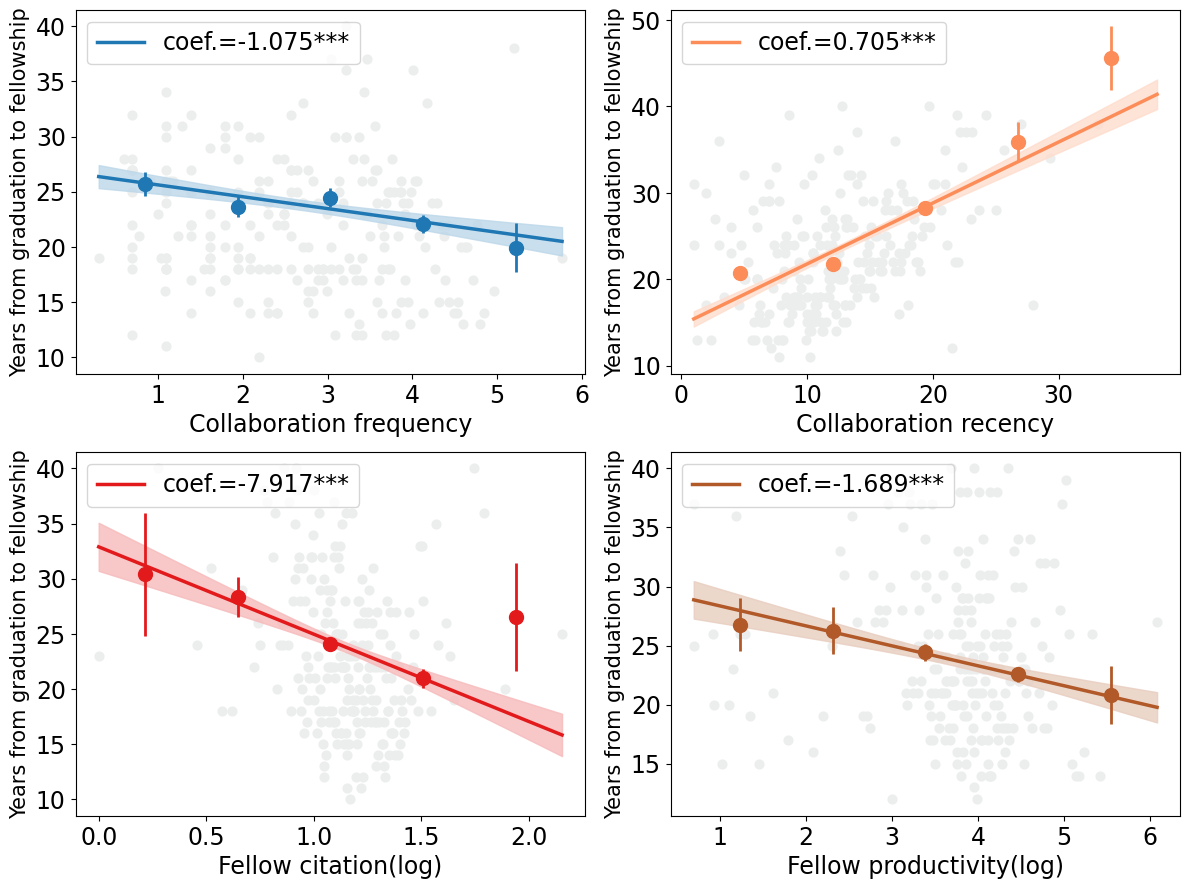

In [3]:
# fig(2)a,b,c,d
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.lines as mlines
from scipy.stats import ttest_ind
from scipy import stats


def darken_color(color, factor):
    r, g, b, a = mcolors.to_rgba(color)
    r = max(0, min(255, r * factor))
    g = max(0, min(255, g * factor))
    b = max(0, min(255, b * factor))
    return (r, g, b, a)


def lighten_color(color, factor):
    r, g, b, a = mcolors.to_rgba(color)
    white = np.array([1, 1, 1])
    new_color = white - (white - np.array([r, g, b])) * factor
    new_color = np.clip(new_color, 0, 1)
    return tuple(new_color) + (a,)


df_a = pd.read_excel("ACM_fellow_characteristic_reproduce.xlsx", engine="openpyxl")
df = df_a[df_a['treated'] == "with fellow"]

colors = ['#1f78b4', '#fc8d59', "#e31a1c", "#b15928"]
text = ["(a)", "(b)", "(c)", "(d)"]


Y = df['Time from PhD to fellow']
independent_vars = ["Collaboration frequency", "collaboration recency", 'Fellow citation(log)', "Fellow productivity(log)"]


fig, axes = plt.subplots(2, 2, figsize=(12, 9))


for c, var in enumerate(independent_vars):
    X = sm.add_constant(df[var])
    i = c//2
    j = c-2*i
    color = colors[c]
    ax = axes[i][j]
    model = sm.OLS(Y, X).fit()

    df_sorted = df.sort_values(by=var).reset_index(drop=True)
    X_sorted = sm.add_constant(df_sorted[var])

    predictions = model.get_prediction(X_sorted)
    frame = predictions.summary_frame(alpha=0.05)

    p_value = model.pvalues[1]
    if p_value < 0.01:
        stars = '***'
    elif p_value < 0.05:
        stars = '**'
    elif p_value < 0.1:
        stars = '*'
    else:
        stars = '(n.s.)'

    # scatter plot, remove extreme points for display purpose
    filtered_data = df_sorted[(df_sorted['Time from PhD to fellow'] <= 40) & (df_sorted['Time from PhD to fellow'] >= 10)]
    filtered_data = filtered_data.iloc[::5]
    axes[i][j].scatter(filtered_data[var], filtered_data['Time from PhD to fellow'], alpha=1, color=darken_color("#F1F3F3",0.98), s=40)

    axes[i][j].plot(df_sorted[var], frame['mean'], color=color, label=f'coef.={model.params[1]:.3f}{stars}',
                     linewidth=2.5)
    axes[i][j].fill_between(df_sorted[var], frame['mean_ci_lower'], frame['mean_ci_upper'], color=lighten_color(color, 0.3), alpha=0.8, edgecolor=lighten_color(color,0.3))

    bin_interval = (df_sorted[var].max() - df_sorted[var].min()) / 5
    bins = np.arange(min(df_sorted[var]), max(df_sorted[var]) + bin_interval, bin_interval)

    df_sorted['group'] = pd.cut(df_sorted[var], bins, include_lowest=True, right=False)

    grouped = df_sorted.groupby('group')['Time from PhD to fellow']
    mean_values = grouped.mean()

    std_error = grouped.std() / np.sqrt(grouped.count()) * 1.96

    for (group, mean), error in zip(mean_values.items(), std_error):
        mid_point = (group.left + group.right) / 2
        axes[i][j].errorbar(mid_point, mean, yerr=error, fmt='o', color=color, alpha=1, markersize=10, elinewidth=2)

    axes[i][j].set_ylabel('Years from graduation to fellowship', fontsize=15)
    axes[i][j].legend(loc="upper left", frameon=True, fontsize=17)
    axes[i][j].tick_params(axis='y', labelsize=17)
    axes[i][j].tick_params(axis='x', labelsize=17)

    if var == "Collaboration frequency":
        ax.set_xlabel("Collaboration frequency", fontsize=17)
    if var == "collaboration recency":
        ax.set_xlabel("Collaboration recency", fontsize=17)
    if var == "Fellow citation(log)":
        ax.set_xlabel("Fellow citation(log)", fontsize=17)
    if var == "Fellow productivity(log)":
        ax.set_xlabel("Fellow productivity(log)", fontsize=17)


plt.tight_layout()
# plt.savefig('fig2(a)(b)(c)(d).svg', format='svg')
plt.show()